<a href="https://colab.research.google.com/github/SDMLABSTUDY/TSP_PROBLEM_1/blob/main/260130_TSP_DEVELOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch;
print("GPU is", "available" if torch.cuda.is_available() else "not available")

GPU is available


In [ ]:

# @title SEED=5, CYCLE마다 개별 결과표 출력용
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive


drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스 정의
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        """
        입력 형식: N, 좌표들..., TimeLimit
        """
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix

        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]

            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1

            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])

        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)

        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]

        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    def print_average_fitness(self, population):
        avg = sum(f for _, f in population) / len(population)
        best = population[0][1]
        # 출력 양이 너무 많으면 이 부분 주석 처리 가능
        # print(f"[Gen] avg_len={avg:.4f}, best_len={best:.4f}")

    def search(self):
        generation = 0
        population = []

        # 1) 초기화
        for _ in range(self.params["POP_SIZE"]):
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))

        population = self.sort_population(population)

        # 2) 시간 및 trace 초기화
        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        # 3) 제한시간 루프
        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []

            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)

                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)

                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부
# ==========================================
if __name__ == "__main__":

    # 3. 대상 파일명 설정
    target_filename = "cycle51.in"

    # 전체 경로 결합
    full_path = os.path.join(base_path, target_filename)

    print(f"Dataset Path: {full_path}")

    # 파일 존재 여부 확인
    if not os.path.exists(full_path):
        print(f"오류: 파일을 찾을 수 없습니다.: {full_path}")
    else:
        print(f"파일을 찾았습니다! 실험을 시작합니다.")


        seeds = [0, 1, 2, 3, 4]

        # 파라미터 설정
        params = {
            'MUT_RATE': 0.2,
            'POP_SIZE': 80,
            'NUM_OFFSPRING': 80,
            'TOURNAMENT_T': 0.7,
            'LOG_INTERVAL_SEC': 0.5, # 로그 간격 조정
        }

        print(f"\n==========================================")
        print(f"[Experiment] {target_filename}")

        # Greedy (Baseline) 계산
        tsp_greedy = TSP_GA(full_path, params, seed=0)
        _, greedy_len = tsp_greedy.greedy_solution()

        # 파일에서 읽어온 제한 시간 확인
        limit_time_val = tsp_greedy.limit_time

        print(f"Greedy(start=0) Len = {greedy_len:.4f}")
        print(f"Time Limit          = {limit_time_val} seconds per seed")
        print("------------------------------------------")
        print(f"{'seed':>4} | {'GA_best_len':>12} | {'improve(%)':>10} | {'Generations':>11}")
        print("-" * 52)

        ga_results = []
        improvements = []

        # 시드별 반복 실행
        for s in seeds:
            # GA 객체 생성
            tsp = TSP_GA(full_path, params, seed=s)

            # 탐색 시작
            best_tour, best_len, gen, elapsed, trace = tsp.search()

            # 개선율 계산
            imp = (greedy_len - best_len) / greedy_len * 100.0

            ga_results.append(best_len)
            improvements.append(imp)

            print(f"{s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

        # 모든 시드 종료 후 최종 요약 출력
        mean_len = statistics.mean(ga_results)
        stdev_len = statistics.stdev(ga_results) if len(seeds) > 1 else 0.0
        mean_imp = statistics.mean(improvements)
        stdev_imp = statistics.stdev(improvements) if len(seeds) > 1 else 0.0

        print("-" * 52)
        print(f"[Summary] {target_filename} (5 Runs)")
        print(f"GA_best_len (Mean ± Std) : {mean_len:.4f} ± {stdev_len:.4f}")
        print(f"Improvement (Mean ± Std) : {mean_imp:.2f}% ± {stdev_imp:.2f}%")
        print("==========================================\n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Path: /content/drive/MyDrive/SDMLAB/260129_TSP/cycle51.in
파일을 찾았습니다! 실험을 시작합니다.

[Experiment] cycle51.in
Greedy(start=0) Len = 792.1301
Time Limit          = 72.0 seconds per seed
------------------------------------------
seed |  GA_best_len | improve(%) | Generations
----------------------------------------------------
   0 |     621.2543 |      21.57 |       59112
   1 |     605.7122 |      23.53 |       58445
   2 |     621.1435 |      21.59 |       59522
   3 |     601.0036 |      24.13 |       57054
   4 |     636.2549 |      19.68 |       59812
----------------------------------------------------
[Summary] cycle51.in (5 Runs)
GA_best_len (Mean ± Std) : 617.0737 ± 14.0472
Improvement (Mean ± Std) : 22.10% ± 1.77%



# 260129_Base exp

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 실험 시작: cycle51.in
👉 비교 파라미터: MUT_RATE = [0.3, 0.2, 0.1, 0.05]
   Greedy Baseline = 792.1301

🟦 [Experiment] MUT_RATE = 0.3
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     629.6902 |      20.51 |       93673
      1 |     629.6520 |      20.51 |       91848
      2 |     627.2821 |      20.81 |       93356
      3 |     612.5336 |      22.67 |       92730
      4 |     620.2870 |      21.69 |       93151
   ---------------------------------------------
   ➡ Avg Best Len: 623.8890 ± 7.4212

🟦 [Experiment] MUT_RATE = 0.2
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     618.7319 |      21.89 |       95389
      1 |     620.2148 |      21.70 |       93213
      2 |     604.7921 |      23.65 |       95798
      3 |     610.4555 |      2

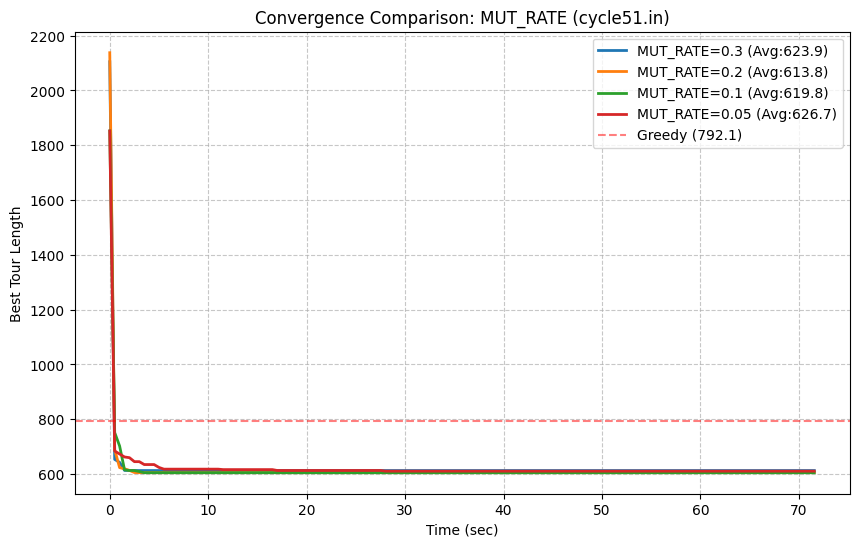

✅ 모든 실험 및 그래프 출력이 완료되었습니다.


In [ ]:

# @title 파라미터 변화 실험 결과표, 수렴곡선 그래프 출력(MUT_RATE, TOURNAMENT_T, POP_SIZE, NUM_OFFSPRING)
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive

# ==========================================
# 1. 구글 드라이브 연결 및 경로 설정
# ==========================================
drive.mount('/content/drive')

# 사용자 경로 (본인 경로에 맞게 수정 필요)
base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix
        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]
            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1
            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])
        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)
        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]
        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    def search(self):
        generation = 0
        population = []
        for _ in range(self.params["POP_SIZE"]):
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))
        population = self.sort_population(population)

        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []
            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)
                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)
                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

            # 조기 종료(Early Stopping) 제거: 시간 끝까지 돔
            # CONV_DOM_RATIO를 1.0보다 크게 설정하여 사실상 비활성화

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부 (실험 설정)
# ==========================================
if __name__ == "__main__":

    # -----------------------------------------------------------
    # [설정 1] 대상 파일 및 시드
    # -----------------------------------------------------------
    target_filename = "cycle51.in"
    full_path = os.path.join(base_path, target_filename)
    seeds = [0, 1, 2, 3, 4]

    # -----------------------------------------------------------
    # [설정 2] 비교할 파라미터 선택 (여기만 바꾸면 됩니다!)
    # -----------------------------------------------------------
    # Exploitation(이용)을 강화하려면?
    # 1) MUT_RATE를 낮춘다 (예: 0.2 -> 0.05) -> 기존의 좋은 해를 덜 파괴함
    # 2) TOURNAMENT_T를 높인다 (예: 0.7 -> 0.9) -> 좋은 부모만 엄격하게 선별함

    target_param = "MUT_RATE"        # 비교할 파라미터 이름 (Key)
    test_values  = [0.3, 0.2, 0.1, 0.05]       # 비교할 값들 (List)

    # 기본 파라미터 (Base Settings)
    base_params = {
        'MUT_RATE': 0.2,
        'POP_SIZE': 120,
        'NUM_OFFSPRING': 50,
        'TOURNAMENT_T': 0.7,
        'LOG_INTERVAL_SEC': 0.5,
        'CONV_MIN_GEN': 50,
        'CONV_CHECK': 10,
        'CONV_DOM_RATIO': 1.1, # [중요] 1.0보다 크면 조기 종료 절대 안 함 (시간 꽉 채움)
    }

    # ===========================================================

    if not os.path.exists(full_path):
        print(f"❌ 오류: 파일을 찾을 수 없습니다: {full_path}")
    else:
        print(f"✅ 실험 시작: {target_filename}")
        print(f"👉 비교 파라미터: {target_param} = {test_values}")

        # 1) Greedy Baseline
        tsp_greedy = TSP_GA(full_path, base_params, seed=0)
        _, greedy_len = tsp_greedy.greedy_solution()
        print(f"   Greedy Baseline = {greedy_len:.4f}\n")

        # 결과 저장용
        plot_data = {}  # { value: (time_trace, best_trace) } -> 그래프용 (가장 잘 된 시드)

        # -------------------------------------------------------
        # 실험 루프 (설정한 값들을 하나씩 테스트)
        # -------------------------------------------------------
        for val in test_values:
            print(f"🟦 [Experiment] {target_param} = {val}")

            # 파라미터 업데이트
            current_params = base_params.copy()
            current_params[target_param] = val

            # POP_SIZE 변경 시 NUM_OFFSPRING도 같이 맞춰주는 편의 로직
            if target_param == 'POP_SIZE':
                current_params['NUM_OFFSPRING'] = val

            # 시드별 결과 저장
            seed_results = []     # best_len 저장
            seed_traces = []      # trace 저장

            print(f"   {'Seed':>4} | {'Best_Len':>12} | {'Improv(%)':>10} | {'Generations':>11}")
            print("   " + "-"*45)

            best_run_score = float('inf')
            best_run_trace = None

            for s in seeds:
                tsp = TSP_GA(full_path, current_params, seed=s)

                # 탐색 수행
                best_tour, best_len, gen, elapsed, trace = tsp.search()

                imp = (greedy_len - best_len) / greedy_len * 100.0
                seed_results.append(best_len)
                seed_traces.append(trace)

                print(f"   {s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

                # 그래프 그리기 위해 "가장 결과가 좋았던 시드"의 궤적을 저장
                if best_len < best_run_score:
                    best_run_score = best_len
                    best_run_trace = trace

            # 평균 계산
            mean_len = statistics.mean(seed_results)
            stdev_len = statistics.stdev(seed_results) if len(seeds)>1 else 0.0
            print("   " + "-"*45)
            print(f"   ➡ Avg Best Len: {mean_len:.4f} ± {stdev_len:.4f}\n")

            # 그래프 데이터 저장 (해당 파라미터 값의 Best Run 궤적)
            plot_data[val] = (best_run_trace, mean_len)

        # -------------------------------------------------------
        # 수렴 곡선 비교 그래프 출력 (Matplotlib)
        # -------------------------------------------------------
        plt.figure(figsize=(10, 6))

        for val, (trace, avg_score) in plot_data.items():
            t_data, best_data = trace
            # 범례에 평균 점수도 같이 표시
            label_str = f"{target_param}={val} (Avg:{avg_score:.1f})"
            plt.plot(t_data, best_data, label=label_str, linewidth=2)

        plt.axhline(y=greedy_len, color='r', linestyle='--', label=f'Greedy ({greedy_len:.1f})', alpha=0.5)

        plt.xlabel("Time (sec)")
        plt.ylabel("Best Tour Length")
        plt.title(f"Convergence Comparison: {target_param} ({target_filename})")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', alpha=0.7)
        plt.show()

In [ ]:
# @title  260129_랩미팅용 수렴곡선 실험했던 코드

if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # 1. 공통 설정
    target_file = "cycle101.in"  # 효과가 가장 잘 보이는 101 사용
    seeds = [0, 1, 2]            # 시드 3개 평균

    # 기준 파라미터 (Baseline)
    base_params = {
        'MUT_RATE': 0.2,
        'POP_SIZE': 80,
        'NUM_OFFSPRING': 80,
        'TOURNAMENT_T': 0.7,
        'CONV_CHECK': 10,
        'CONV_MIN_GEN': 50,
        'CONV_DOM_RATIO': 1.1, # 비교를 위해 조기종료 끔
    }

    print(f"=== Parameter Sensitivity Analysis: {target_file} ===")

    # ====================================================
    # 실험 설계 (OFAT: One-Factor-At-a-Time)
    # 선정해주신 값들로 구성
    # ====================================================
    experiments = {
        "1_Mutation_Rate":  ("MUT_RATE", [0.2, 0.4]),
        "2_Tournament_T":   ("TOURNAMENT_T", [0.7, 0.5]),
        "3_Population_Size":("POP_SIZE", [80, 120, 200])
    }

    # 각 실험 수행
    for exp_name, (param_key, param_values) in experiments.items():
        print(f"\n>> Experiment: Changing {param_key} ...")

        plt.figure(figsize=(10, 6))

        # 각 값에 대해 실행
        for val in param_values:
            # 파라미터 설정 (Baseline 복사 후 해당 파라미터만 변경)
            curr_params = base_params.copy()
            curr_params[param_key] = val

            # POP_SIZE 바꿀 땐 OFFSPRING도 같이 맞춰주는 게 일반적
            if param_key == "POP_SIZE":
                curr_params["NUM_OFFSPRING"] = val

            # 실험 실행
            res = run_experiment(target_file, curr_params, seeds, disable_early_stop=True, verbose_table=False)

            # 결과 추출
            t_trace, len_trace = res["best_trace"]  # 대표 trace
            mean_score = res["ga_mean"]             # 평균 점수

            # 그래프 플롯
            plt.plot(t_trace, len_trace, label=f"{param_key}={val} (Avg:{mean_score:.1f})", linewidth=2)
            print(f"   [{param_key}={val}] Avg Best Len: {mean_score:.4f}")

        # 그래프 꾸미기 및 저장
        plt.xlabel("Time (sec)")
        plt.ylabel("Best Tour Length")
        plt.title(f"Impact of {param_key} on Convergence ({target_file})")
        plt.legend()
        plt.grid(True)

        save_name = f"param_final_{exp_name}.png"
        plt.savefig(save_name)
        print(f"   -> Graph saved: {save_name}")
        plt.close() # 다음 그래프를 위해 닫기

    print("\n모든 파라미터 실험이 완료되었습니다. 생성된 3개의 이미지를 확인하세요.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 실험 시작: cycle51.in
👉 비교 파라미터: MUT_RATE = [0.25, 0.2, 0.15]
👉 전략: Greedy Solution을 초기 집단에 포함(Seeding) + 시간 꽉 채우기
   Greedy Seed Score = 792.1301 (이 경로를 GA 초기값으로 씁니다)

🟦 [Experiment] MUT_RATE = 0.25
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     604.3763 |      23.70 |       87758
      1 |     609.1286 |      23.10 |       88859
      2 |     621.9445 |      21.48 |       89005
      3 |     599.2101 |      24.35 |       86326
      4 |     599.4984 |      24.32 |       88929
   ---------------------------------------------
   ➡ Avg Best Len: 606.8316 ± 9.3750

🟦 [Experiment] MUT_RATE = 0.2
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     599.3200 |      24.34 |       88986
      1 |     602.4197 |      23.95 |       87579
      2 

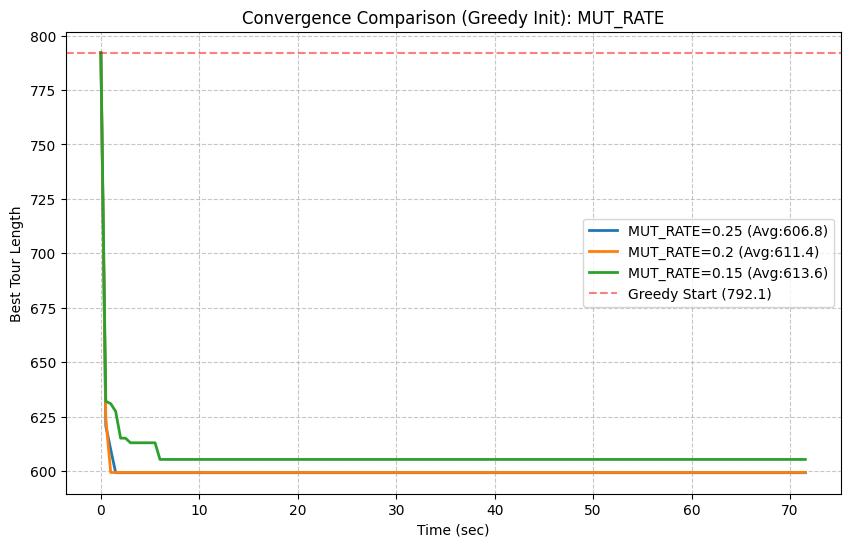

In [ ]:
# @title 260202_greedy
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive

# ==========================================
# 1. 구글 드라이브 연결 및 경로 설정
# ==========================================
drive.mount('/content/drive')

# 사용자 경로 (본인 경로에 맞게 수정 필요)
base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix
        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]
            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1
            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])
        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)
        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]
        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    # [수정됨] init_tours 인자를 받아서 초기 집단에 포함시키는 기능 추가
    def search(self, init_tours=None):
        generation = 0
        population = []

        # 1-1) Greedy Seed 주입 (있다면)
        if init_tours:
            for tour in init_tours:
                if len(population) < self.params["POP_SIZE"]:
                    fit = self.get_fitness(tour)
                    population.append((tour, fit))

        # 1-2) 나머지는 랜덤 해로 채우기
        while len(population) < self.params["POP_SIZE"]:
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))

        population = self.sort_population(population)

        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []
            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)
                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)
                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

            # 조기 종료(Early Stopping) 제거

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부 (실험 설정)
# ==========================================
if __name__ == "__main__":

    # -----------------------------------------------------------
    # [설정 1] 대상 파일 및 시드
    # -----------------------------------------------------------
    target_filename = "cycle51.in"
    full_path = os.path.join(base_path, target_filename)
    seeds = [0, 1, 2, 3, 4]

    # -----------------------------------------------------------
    # [설정 2] 비교할 파라미터 선택
    # -----------------------------------------------------------
    # Greedy Init을 쓰므로 Exploit 성향이 강해집니다.
    # 더 강한 Exploit을 원하면 MUT_RATE를 낮추고 TOURNAMENT_T를 높게 설정해보세요.

    target_param = "MUT_RATE"
    test_values  = [0.25, 0.2, 0.15]

    # 기본 파라미터
    base_params = {
        'MUT_RATE': 0.2,
        'POP_SIZE': 120,
        'NUM_OFFSPRING': 50,
        'TOURNAMENT_T': 0.7,
        'LOG_INTERVAL_SEC': 0.5,
        'CONV_MIN_GEN': 50,
        'CONV_CHECK': 10,
        'CONV_DOM_RATIO': 1.1,
    }

    # ===========================================================

    if not os.path.exists(full_path):
        print(f"❌ 오류: 파일을 찾을 수 없습니다: {full_path}")
    else:
        print(f"✅ 실험 시작: {target_filename}")
        print(f"👉 비교 파라미터: {target_param} = {test_values}")
        print(f"👉 전략: Greedy Solution을 초기 집단에 포함(Seeding) + 시간 꽉 채우기")

        # -------------------------------------------------------
        # 1) 공통 Greedy Baseline 계산 (초기값으로 쓸 것)
        # -------------------------------------------------------
        tsp_baseline = TSP_GA(full_path, base_params, seed=0)
        baseline_tour, baseline_len = tsp_baseline.greedy_solution()
        print(f"   Greedy Seed Score = {baseline_len:.4f} (이 경로를 GA 초기값으로 씁니다)\n")

        plot_data = {}

        # -------------------------------------------------------
        # 실험 루프
        # -------------------------------------------------------
        for val in test_values:
            print(f"🟦 [Experiment] {target_param} = {val}")

            current_params = base_params.copy()
            current_params[target_param] = val

            if target_param == 'POP_SIZE':
                current_params['NUM_OFFSPRING'] = val

            seed_results = []
            seed_traces = []

            print(f"   {'Seed':>4} | {'Best_Len':>12} | {'Improv(%)':>10} | {'Generations':>11}")
            print("   " + "-"*45)

            best_run_score = float('inf')
            best_run_trace = None

            for s in seeds:
                tsp = TSP_GA(full_path, current_params, seed=s)

                # [수정됨] 여기서 greedy baseline(baseline_tour)를 초기값으로 넘겨줍니다!
                # init_tours 리스트에 넣어 전달
                best_tour, best_len, gen, elapsed, trace = tsp.search(init_tours=[baseline_tour])

                imp = (baseline_len - best_len) / baseline_len * 100.0
                seed_results.append(best_len)
                seed_traces.append(trace)

                print(f"   {s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

                if best_len < best_run_score:
                    best_run_score = best_len
                    best_run_trace = trace

            mean_len = statistics.mean(seed_results)
            stdev_len = statistics.stdev(seed_results) if len(seeds)>1 else 0.0
            print("   " + "-"*45)
            print(f"   ➡ Avg Best Len: {mean_len:.4f} ± {stdev_len:.4f}\n")

            plot_data[val] = (best_run_trace, mean_len)

        # -------------------------------------------------------
        # 수렴 곡선 출력
        # -------------------------------------------------------
        plt.figure(figsize=(10, 6))

        for val, (trace, avg_score) in plot_data.items():
            t_data, best_data = trace
            label_str = f"{target_param}={val} (Avg:{avg_score:.1f})"
            plt.plot(t_data, best_data, label=label_str, linewidth=2)

        # Greedy 기준선 표시 (빨간 점선)
        plt.axhline(y=baseline_len, color='r', linestyle='--', label=f'Greedy Start ({baseline_len:.1f})', alpha=0.5)

        plt.xlabel("Time (sec)")
        plt.ylabel("Best Tour Length")
        plt.title(f"Convergence Comparison (Greedy Init): {target_param}")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', alpha=0.7)
        plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 실험 시작: cycle51.in
👉 비교 파라미터: POP_SIZE = [80, 120, 150]
   Greedy Baseline = 792.1301

🟦 [Experiment] POP_SIZE = 80
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     621.2543 |      21.57 |       54833
      1 |     605.7122 |      23.53 |       54707
      2 |     621.1435 |      21.59 |       55744
      3 |     601.0036 |      24.13 |       56063
      4 |     636.2549 |      19.68 |       54936
   ---------------------------------------------
   ➡ Avg Best Len: 617.0737 ± 14.0472

🟦 [Experiment] POP_SIZE = 120
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     610.8772 |      22.88 |       37610
      1 |     611.4157 |      22.81 |       37240
      2 |     599.8164 |      24.28 |       36331
      3 |     601.9623 |      24.01 | 

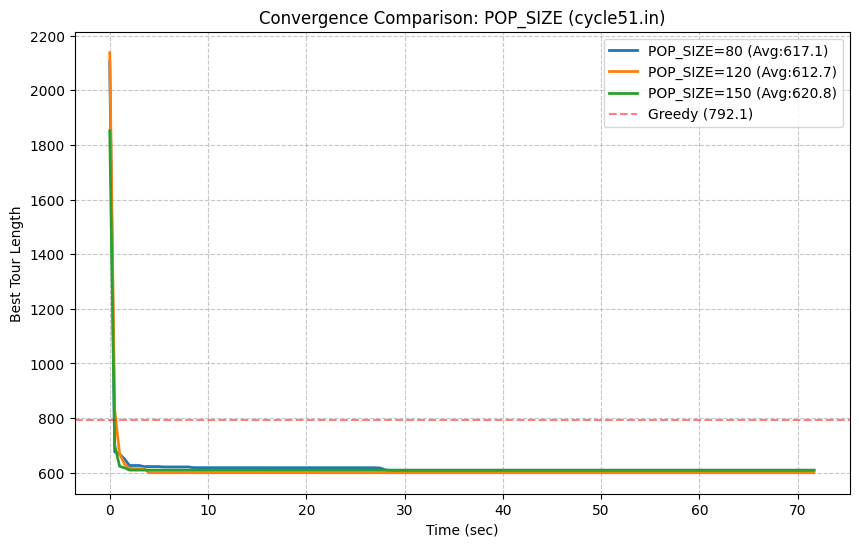

In [ ]:
# @title 260202_POP_SIZE(NUM_OFFSPRING=60)
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive

# ==========================================
# 1. 구글 드라이브 연결 및 경로 설정
# ==========================================
drive.mount('/content/drive')

# 사용자 경로 (본인 경로에 맞게 수정 필요)
base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix
        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]
            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1
            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])
        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)
        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]
        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    def search(self):
        generation = 0
        population = []
        for _ in range(self.params["POP_SIZE"]):
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))
        population = self.sort_population(population)

        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []
            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)
                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)
                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

            # 조기 종료(Early Stopping) 제거: 시간 끝까지 돔
            # CONV_DOM_RATIO를 1.0보다 크게 설정하여 사실상 비활성화

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부 (실험 설정)
# ==========================================
if __name__ == "__main__":

    # -----------------------------------------------------------
    # [설정 1] 대상 파일 및 시드
    # -----------------------------------------------------------
    target_filename = "cycle51.in"
    full_path = os.path.join(base_path, target_filename)
    seeds = [0, 1, 2, 3, 4]

    # -----------------------------------------------------------
    # [설정 2] 비교할 파라미터 선택 (여기만 바꾸면 됩니다!)
    # -----------------------------------------------------------
    # Exploitation(이용)을 강화하려면?
    # 1) MUT_RATE를 낮춘다 (예: 0.2 -> 0.05) -> 기존의 좋은 해를 덜 파괴함
    # 2) TOURNAMENT_T를 높인다 (예: 0.7 -> 0.9) -> 좋은 부모만 엄격하게 선별함

    target_param = "POP_SIZE"        # 비교할 파라미터 이름 (Key)
    test_values  = [80, 120, 150]       # 비교할 값들 (List)

    # 기본 파라미터 (Base Settings)
    base_params = {
        'MUT_RATE': 0.2,
        'POP_SIZE': 120,
        'NUM_OFFSPRING': 60,
        'TOURNAMENT_T': 0.7,
        'LOG_INTERVAL_SEC': 0.5,
        'CONV_MIN_GEN': 50,
        'CONV_CHECK': 10,
        'CONV_DOM_RATIO': 1.1, # [중요] 1.0보다 크면 조기 종료 절대 안 함 (시간 꽉 채움)
    }

    # ===========================================================

    if not os.path.exists(full_path):
        print(f"❌ 오류: 파일을 찾을 수 없습니다: {full_path}")
    else:
        print(f"✅ 실험 시작: {target_filename}")
        print(f"👉 비교 파라미터: {target_param} = {test_values}")

        # 1) Greedy Baseline
        tsp_greedy = TSP_GA(full_path, base_params, seed=0)
        _, greedy_len = tsp_greedy.greedy_solution()
        print(f"   Greedy Baseline = {greedy_len:.4f}\n")

        # 결과 저장용
        plot_data = {}  # { value: (time_trace, best_trace) } -> 그래프용 (가장 잘 된 시드)

        # -------------------------------------------------------
        # 실험 루프 (설정한 값들을 하나씩 테스트)
        # -------------------------------------------------------
        for val in test_values:
            print(f"🟦 [Experiment] {target_param} = {val}")

            # 파라미터 업데이트
            current_params = base_params.copy()
            current_params[target_param] = val

            # POP_SIZE 변경 시 NUM_OFFSPRING도 같이 맞춰주는 편의 로직
            if target_param == 'POP_SIZE':
                current_params['NUM_OFFSPRING'] = val

            # 시드별 결과 저장
            seed_results = []     # best_len 저장
            seed_traces = []      # trace 저장

            print(f"   {'Seed':>4} | {'Best_Len':>12} | {'Improv(%)':>10} | {'Generations':>11}")
            print("   " + "-"*45)

            best_run_score = float('inf')
            best_run_trace = None

            for s in seeds:
                tsp = TSP_GA(full_path, current_params, seed=s)

                # 탐색 수행
                best_tour, best_len, gen, elapsed, trace = tsp.search()

                imp = (greedy_len - best_len) / greedy_len * 100.0
                seed_results.append(best_len)
                seed_traces.append(trace)

                print(f"   {s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

                # 그래프 그리기 위해 "가장 결과가 좋았던 시드"의 궤적을 저장
                if best_len < best_run_score:
                    best_run_score = best_len
                    best_run_trace = trace

            # 평균 계산
            mean_len = statistics.mean(seed_results)
            stdev_len = statistics.stdev(seed_results) if len(seeds)>1 else 0.0
            print("   " + "-"*45)
            print(f"   ➡ Avg Best Len: {mean_len:.4f} ± {stdev_len:.4f}\n")

            # 그래프 데이터 저장 (해당 파라미터 값의 Best Run 궤적)
            plot_data[val] = (best_run_trace, mean_len)

        # -------------------------------------------------------
        # 수렴 곡선 비교 그래프 출력 (Matplotlib)
        # -------------------------------------------------------
        plt.figure(figsize=(10, 6))

        for val, (trace, avg_score) in plot_data.items():
            t_data, best_data = trace
            # 범례에 평균 점수도 같이 표시
            label_str = f"{target_param}={val} (Avg:{avg_score:.1f})"
            plt.plot(t_data, best_data, label=label_str, linewidth=2)

        plt.axhline(y=greedy_len, color='r', linestyle='--', label=f'Greedy ({greedy_len:.1f})', alpha=0.5)

        plt.xlabel("Time (sec)")
        plt.ylabel("Best Tour Length")
        plt.title(f"Convergence Comparison: {target_param} ({target_filename})")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', alpha=0.7)
        plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 실험 시작: cycle51.in
👉 비교 파라미터: POP_SIZE = [110, 120, 130]
   Greedy Baseline = 792.1301

🟦 [Experiment] POP_SIZE = 110
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     614.8761 |      22.38 |       38318
      1 |     623.4443 |      21.30 |       34069
      2 |     616.3257 |      22.19 |       38771
      3 |     615.3879 |      22.31 |       40503
      4 |     633.0630 |      20.08 |       40656
   ---------------------------------------------
   ➡ Avg Best Len: 620.6194 ± 7.7720

🟦 [Experiment] POP_SIZE = 120
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     610.8772 |      22.88 |       36059
      1 |     611.4157 |      22.81 |       36902
      2 |     599.8164 |      24.28 |       36705
      3 |     601.9623 |      24.01 |

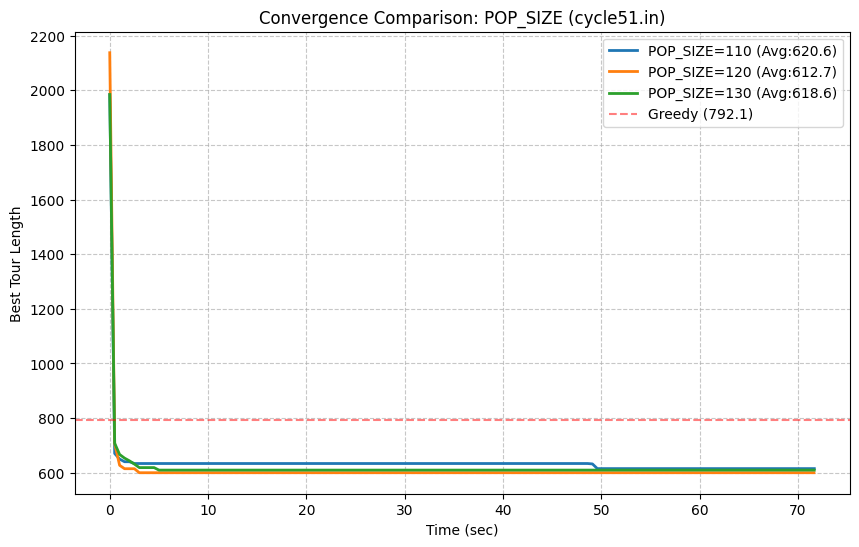

In [ ]:
# @title 260202_POP_SIZE(NUM_OFFSPRING=80)
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive

# ==========================================
# 1. 구글 드라이브 연결 및 경로 설정
# ==========================================
drive.mount('/content/drive')

# 사용자 경로 (본인 경로에 맞게 수정 필요)
base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix
        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]
            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1
            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])
        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)
        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]
        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    def search(self):
        generation = 0
        population = []
        for _ in range(self.params["POP_SIZE"]):
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))
        population = self.sort_population(population)

        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []
            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)
                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)
                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

            # 조기 종료(Early Stopping) 제거: 시간 끝까지 돔
            # CONV_DOM_RATIO를 1.0보다 크게 설정하여 사실상 비활성화

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부 (실험 설정)
# ==========================================
if __name__ == "__main__":

    # -----------------------------------------------------------
    # [설정 1] 대상 파일 및 시드
    # -----------------------------------------------------------
    target_filename = "cycle51.in"
    full_path = os.path.join(base_path, target_filename)
    seeds = [0, 1, 2, 3, 4]

    # -----------------------------------------------------------
    # [설정 2] 비교할 파라미터 선택 (여기만 바꾸면 됩니다!)
    # -----------------------------------------------------------
    # Exploitation(이용)을 강화하려면?
    # 1) MUT_RATE를 낮춘다 (예: 0.2 -> 0.05) -> 기존의 좋은 해를 덜 파괴함
    # 2) TOURNAMENT_T를 높인다 (예: 0.7 -> 0.9) -> 좋은 부모만 엄격하게 선별함

    target_param = "POP_SIZE"        # 비교할 파라미터 이름 (Key)
    test_values  = [110, 120, 130]       # 비교할 값들 (List)

    # 기본 파라미터 (Base Settings)
    base_params = {
        'MUT_RATE': 0.2,
        'POP_SIZE': 120,
        'NUM_OFFSPRING': 80,
        'TOURNAMENT_T': 0.7,
        'LOG_INTERVAL_SEC': 0.5,
        'CONV_MIN_GEN': 50,
        'CONV_CHECK': 10,
        'CONV_DOM_RATIO': 1.1, # [중요] 1.0보다 크면 조기 종료 절대 안 함 (시간 꽉 채움)
    }

    # ===========================================================

    if not os.path.exists(full_path):
        print(f"❌ 오류: 파일을 찾을 수 없습니다: {full_path}")
    else:
        print(f"✅ 실험 시작: {target_filename}")
        print(f"👉 비교 파라미터: {target_param} = {test_values}")

        # 1) Greedy Baseline
        tsp_greedy = TSP_GA(full_path, base_params, seed=0)
        _, greedy_len = tsp_greedy.greedy_solution()
        print(f"   Greedy Baseline = {greedy_len:.4f}\n")

        # 결과 저장용
        plot_data = {}  # { value: (time_trace, best_trace) } -> 그래프용 (가장 잘 된 시드)

        # -------------------------------------------------------
        # 실험 루프 (설정한 값들을 하나씩 테스트)
        # -------------------------------------------------------
        for val in test_values:
            print(f"🟦 [Experiment] {target_param} = {val}")

            # 파라미터 업데이트
            current_params = base_params.copy()
            current_params[target_param] = val

            # POP_SIZE 변경 시 NUM_OFFSPRING도 같이 맞춰주는 편의 로직
            if target_param == 'POP_SIZE':
                current_params['NUM_OFFSPRING'] = val

            # 시드별 결과 저장
            seed_results = []     # best_len 저장
            seed_traces = []      # trace 저장

            print(f"   {'Seed':>4} | {'Best_Len':>12} | {'Improv(%)':>10} | {'Generations':>11}")
            print("   " + "-"*45)

            best_run_score = float('inf')
            best_run_trace = None

            for s in seeds:
                tsp = TSP_GA(full_path, current_params, seed=s)

                # 탐색 수행
                best_tour, best_len, gen, elapsed, trace = tsp.search()

                imp = (greedy_len - best_len) / greedy_len * 100.0
                seed_results.append(best_len)
                seed_traces.append(trace)

                print(f"   {s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

                # 그래프 그리기 위해 "가장 결과가 좋았던 시드"의 궤적을 저장
                if best_len < best_run_score:
                    best_run_score = best_len
                    best_run_trace = trace

            # 평균 계산
            mean_len = statistics.mean(seed_results)
            stdev_len = statistics.stdev(seed_results) if len(seeds)>1 else 0.0
            print("   " + "-"*45)
            print(f"   ➡ Avg Best Len: {mean_len:.4f} ± {stdev_len:.4f}\n")

            # 그래프 데이터 저장 (해당 파라미터 값의 Best Run 궤적)
            plot_data[val] = (best_run_trace, mean_len)

        # -------------------------------------------------------
        # 수렴 곡선 비교 그래프 출력 (Matplotlib)
        # -------------------------------------------------------
        plt.figure(figsize=(10, 6))

        for val, (trace, avg_score) in plot_data.items():
            t_data, best_data = trace
            # 범례에 평균 점수도 같이 표시
            label_str = f"{target_param}={val} (Avg:{avg_score:.1f})"
            plt.plot(t_data, best_data, label=label_str, linewidth=2)

        plt.axhline(y=greedy_len, color='r', linestyle='--', label=f'Greedy ({greedy_len:.1f})', alpha=0.5)

        plt.xlabel("Time (sec)")
        plt.ylabel("Best Tour Length")
        plt.title(f"Convergence Comparison: {target_param} ({target_filename})")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', alpha=0.7)
        plt.show()

# 0202_Best params greedy exp

In [ ]:
# @title best params without greedy(random initialization)
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive


drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스 정의
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        """
        입력 형식: N, 좌표들..., TimeLimit
        """
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix

        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]

            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1

            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])

        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)

        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]

        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    def print_average_fitness(self, population):
        avg = sum(f for _, f in population) / len(population)
        best = population[0][1]
        # 출력 양이 너무 많으면 이 부분 주석 처리 가능
        # print(f"[Gen] avg_len={avg:.4f}, best_len={best:.4f}")

    def search(self):
        generation = 0
        population = []

        # 1) 초기화
        for _ in range(self.params["POP_SIZE"]):
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))

        population = self.sort_population(population)

        # 2) 시간 및 trace 초기화
        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        # 3) 제한시간 루프
        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []

            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)

                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)

                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부
# ==========================================
if __name__ == "__main__":

    # 3. 대상 파일명 설정
    target_filename = "cycle51.in"

    # 전체 경로 결합
    full_path = os.path.join(base_path, target_filename)

    print(f"Dataset Path: {full_path}")

    # 파일 존재 여부 확인
    if not os.path.exists(full_path):
        print(f"오류: 파일을 찾을 수 없습니다.: {full_path}")
    else:
        print(f"파일을 찾았습니다! 실험을 시작합니다.")


        seeds = [0, 1, 2, 3, 4]

        # 파라미터 설정
        params = {
            'MUT_RATE': 0.25,
            'POP_SIZE': 120,
            'NUM_OFFSPRING': 70,
            'TOURNAMENT_T': 0.8,
            'LOG_INTERVAL_SEC': 0.5, # 로그 간격 조정
        }

        print(f"\n==========================================")
        print(f"[Experiment] {target_filename}")

        # Greedy (Baseline) 계산
        tsp_greedy = TSP_GA(full_path, params, seed=0)
        _, greedy_len = tsp_greedy.greedy_solution()

        # 파일에서 읽어온 제한 시간 확인
        limit_time_val = tsp_greedy.limit_time

        print(f"Greedy(start=0) Len = {greedy_len:.4f}")
        print(f"Time Limit          = {limit_time_val} seconds per seed")
        print("------------------------------------------")
        print(f"{'seed':>4} | {'GA_best_len':>12} | {'improve(%)':>10} | {'Generations':>11}")
        print("-" * 52)

        ga_results = []
        improvements = []

        # 시드별 반복 실행
        for s in seeds:
            # GA 객체 생성
            tsp = TSP_GA(full_path, params, seed=s)

            # 탐색 시작
            best_tour, best_len, gen, elapsed, trace = tsp.search()

            # 개선율 계산
            imp = (greedy_len - best_len) / greedy_len * 100.0

            ga_results.append(best_len)
            improvements.append(imp)

            print(f"{s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

        # 모든 시드 종료 후 최종 요약 출력
        mean_len = statistics.mean(ga_results)
        stdev_len = statistics.stdev(ga_results) if len(seeds) > 1 else 0.0
        mean_imp = statistics.mean(improvements)
        stdev_imp = statistics.stdev(improvements) if len(seeds) > 1 else 0.0

        print("-" * 52)
        print(f"[Summary] {target_filename} (5 Runs)")
        print(f"GA_best_len (Mean ± Std) : {mean_len:.4f} ± {stdev_len:.4f}")
        print(f"Improvement (Mean ± Std) : {mean_imp:.2f}% ± {stdev_imp:.2f}%")
        print("==========================================\n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Path: /content/drive/MyDrive/SDMLAB/260129_TSP/cycle51.in
파일을 찾았습니다! 실험을 시작합니다.

[Experiment] cycle51.in
Greedy(start=0) Len = 792.1301
Time Limit          = 72.0 seconds per seed
------------------------------------------
seed |  GA_best_len | improve(%) | Generations
----------------------------------------------------
   0 |     624.9713 |      21.10 |       50911
   1 |     615.5551 |      22.29 |       60663
   2 |     627.7744 |      20.75 |       51795
   3 |     621.4525 |      21.55 |       52365
   4 |     590.3803 |      25.47 |       55265
----------------------------------------------------
[Summary] cycle51.in (5 Runs)
GA_best_len (Mean ± Std) : 616.0267 ± 15.0451
Improvement (Mean ± Std) : 22.23% ± 1.90%



In [ ]:
# @title Best params + greedy
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive

# ==========================================
# 1. 구글 드라이브 연결 및 경로 설정
# ==========================================
drive.mount('/content/drive')

# 사용자 경로 (본인 경로에 맞게 수정 필요)
base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix
        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]
            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1
            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])
        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)
        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]
        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    def print_average_fitness(self, population):
        avg = sum(f for _, f in population) / len(population)
        best = population[0][1]
        # print(f"[Gen] avg_len={avg:.4f}, best_len={best:.4f}")

    # [수정] 외부에서 초기 해(Greedy)를 받아올 수 있도록 init_tours 매개변수 추가
    def search(self, init_tours=None):
        generation = 0
        population = []

        # 1-1) Greedy Seed 주입 (전달받은 해가 있다면 우선 추가)
        if init_tours:
            for tour in init_tours:
                if len(population) < self.params["POP_SIZE"]:
                    fit = self.get_fitness(tour)
                    population.append((tour, fit))

        # 1-2) 남은 자리는 랜덤 해로 채우기
        while len(population) < self.params["POP_SIZE"]:
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))

        population = self.sort_population(population)

        # 2) 시간 및 trace 초기화
        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        # 3) 제한시간 루프
        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []

            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)

                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)

                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

            # 조기 종료(Early Stopping) 제거: 시간 끝까지 돔
            # CONV_DOM_RATIO를 1.0보다 크게 설정하여 사실상 비활성화

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부
# ==========================================
if __name__ == "__main__":

    # 3. 대상 파일명 설정
    target_filename = "cycle51.in"

    # 전체 경로 결합
    full_path = os.path.join(base_path, target_filename)

    print(f"Dataset Path: {full_path}")

    # 파일 존재 여부 확인
    if not os.path.exists(full_path):
        print(f"❌ 오류: 파일을 찾을 수 없습니다.: {full_path}")
    else:
        print(f"✅ 파일을 찾았습니다! 실험을 시작합니다.")

        seeds = [0, 1, 2, 3, 4]

        # 파라미터 설정
        params = {
            'MUT_RATE': 0.25,
            'POP_SIZE': 120,
            'NUM_OFFSPRING': 70,
            'TOURNAMENT_T': 0.8,
            'LOG_INTERVAL_SEC': 0.5, # 로그 간격 조정
            # 조기 종료를 사실상 끄기 위해 비율을 1.0 초과로 설정
            'CONV_DOM_RATIO': 1.1,
        }

        print(f"\n==========================================")
        print(f"[Experiment] {target_filename} (With Greedy Init)")

        # 1) Greedy (Baseline) 계산 및 경로 저장
        tsp_greedy = TSP_GA(full_path, params, seed=0)
        greedy_tour, greedy_len = tsp_greedy.greedy_solution() # [중요] 경로(greedy_tour)도 받음

        # 파일에서 읽어온 제한 시간 확인
        limit_time_val = tsp_greedy.limit_time

        print(f"Greedy(start=0) Len = {greedy_len:.4f}")
        print(f"Time Limit          = {limit_time_val} seconds per seed")
        print("------------------------------------------")
        print(f"{'seed':>4} | {'GA_best_len':>12} | {'improve(%)':>10} | {'Generations':>11}")
        print("-" * 52)

        ga_results = []
        improvements = []

        # 시드별 반복 실행
        for s in seeds:
            # GA 객체 생성
            tsp = TSP_GA(full_path, params, seed=s)

            # [수정] Greedy 경로를 초기값 리스트에 담아 전달
            best_tour, best_len, gen, elapsed, trace = tsp.search(init_tours=[greedy_tour])

            # 개선율 계산
            imp = (greedy_len - best_len) / greedy_len * 100.0

            ga_results.append(best_len)
            improvements.append(imp)

            print(f"{s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

        # 모든 시드 종료 후 최종 요약 출력
        mean_len = statistics.mean(ga_results)
        stdev_len = statistics.stdev(ga_results) if len(seeds) > 1 else 0.0
        mean_imp = statistics.mean(improvements)
        stdev_imp = statistics.stdev(improvements) if len(seeds) > 1 else 0.0

        print("-" * 52)
        print(f"[Summary] {target_filename} (5 Runs)")
        print(f"GA_best_len (Mean ± Std) : {mean_len:.4f} ± {stdev_len:.4f}")
        print(f"Improvement (Mean ± Std) : {mean_imp:.2f}% ± {stdev_imp:.2f}%")
        print("==========================================\n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Path: /content/drive/MyDrive/SDMLAB/260129_TSP/cycle51.in
✅ 파일을 찾았습니다! 실험을 시작합니다.

[Experiment] cycle51.in (With Greedy Init)
Greedy(start=0) Len = 792.1301
Time Limit          = 72.0 seconds per seed
------------------------------------------
seed |  GA_best_len | improve(%) | Generations
----------------------------------------------------
   0 |     622.1955 |      21.45 |       54764
   1 |     604.3164 |      23.71 |       62983
   2 |     610.2953 |      22.96 |       53671
   3 |     610.8850 |      22.88 |       63124
   4 |     616.6695 |      22.15 |       64062
----------------------------------------------------
[Summary] cycle51.in (5 Runs)
GA_best_len (Mean ± Std) : 612.8723 ± 6.8032
Improvement (Mean ± Std) : 22.63% ± 0.86%



# 260203_CYCLE 101_exp

In [ ]:
# @title Best params + greedy
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive

# ==========================================
# 1. 구글 드라이브 연결 및 경로 설정
# ==========================================
drive.mount('/content/drive')

# 사용자 경로 (본인 경로에 맞게 수정 필요)
base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix
        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]
            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1
            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])
        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)
        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]
        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    def print_average_fitness(self, population):
        avg = sum(f for _, f in population) / len(population)
        best = population[0][1]
        # print(f"[Gen] avg_len={avg:.4f}, best_len={best:.4f}")

    # [수정] 외부에서 초기 해(Greedy)를 받아올 수 있도록 init_tours 매개변수 추가
    def search(self, init_tours=None):
        generation = 0
        population = []

        # 1-1) Greedy Seed 주입 (전달받은 해가 있다면 우선 추가)
        if init_tours:
            for tour in init_tours:
                if len(population) < self.params["POP_SIZE"]:
                    fit = self.get_fitness(tour)
                    population.append((tour, fit))

        # 1-2) 남은 자리는 랜덤 해로 채우기
        while len(population) < self.params["POP_SIZE"]:
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))

        population = self.sort_population(population)

        # 2) 시간 및 trace 초기화
        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        # 3) 제한시간 루프
        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []

            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)

                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)

                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

            # 조기 종료(Early Stopping) 제거: 시간 끝까지 돔
            # CONV_DOM_RATIO를 1.0보다 크게 설정하여 사실상 비활성화

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부
# ==========================================
if __name__ == "__main__":

    # 3. 대상 파일명 설정
    target_filename = "cycle101.in"

    # 전체 경로 결합
    full_path = os.path.join(base_path, target_filename)

    print(f"Dataset Path: {full_path}")

    # 파일 존재 여부 확인
    if not os.path.exists(full_path):
        print(f"❌ 오류: 파일을 찾을 수 없습니다.: {full_path}")
    else:
        print(f"✅ 파일을 찾았습니다! 실험을 시작합니다.")

        seeds = [0, 1, 2, 3, 4]

        # 파라미터 설정
        params = {
            'MUT_RATE': 0.25,
            'POP_SIZE': 120,
            'NUM_OFFSPRING': 70,
            'TOURNAMENT_T': 0.8,
            'LOG_INTERVAL_SEC': 0.5, # 로그 간격 조정
            # 조기 종료를 사실상 끄기 위해 비율을 1.0 초과로 설정
            'CONV_DOM_RATIO': 1.1,
        }

        print(f"\n==========================================")
        print(f"[Experiment] {target_filename} (With Greedy Init)")

        # 1) Greedy (Baseline) 계산 및 경로 저장
        tsp_greedy = TSP_GA(full_path, params, seed=0)
        greedy_tour, greedy_len = tsp_greedy.greedy_solution() # [중요] 경로(greedy_tour)도 받음

        # 파일에서 읽어온 제한 시간 확인
        limit_time_val = tsp_greedy.limit_time

        print(f"Greedy(start=0) Len = {greedy_len:.4f}")
        print(f"Time Limit          = {limit_time_val} seconds per seed")
        print("------------------------------------------")
        print(f"{'seed':>4} | {'GA_best_len':>12} | {'improve(%)':>10} | {'Generations':>11}")
        print("-" * 52)

        ga_results = []
        improvements = []

        # 시드별 반복 실행
        for s in seeds:
            # GA 객체 생성
            tsp = TSP_GA(full_path, params, seed=s)

            # [수정] Greedy 경로를 초기값 리스트에 담아 전달
            best_tour, best_len, gen, elapsed, trace = tsp.search(init_tours=[greedy_tour])

            # 개선율 계산
            imp = (greedy_len - best_len) / greedy_len * 100.0

            ga_results.append(best_len)
            improvements.append(imp)

            print(f"{s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

        # 모든 시드 종료 후 최종 요약 출력
        mean_len = statistics.mean(ga_results)
        stdev_len = statistics.stdev(ga_results) if len(seeds) > 1 else 0.0
        mean_imp = statistics.mean(improvements)
        stdev_imp = statistics.stdev(improvements) if len(seeds) > 1 else 0.0

        print("-" * 52)
        print(f"[Summary] {target_filename} (5 Runs)")
        print(f"GA_best_len (Mean ± Std) : {mean_len:.4f} ± {stdev_len:.4f}")
        print(f"Improvement (Mean ± Std) : {mean_imp:.2f}% ± {stdev_imp:.2f}%")
        print("==========================================\n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Path: /content/drive/MyDrive/SDMLAB/260129_TSP/cycle101.in
✅ 파일을 찾았습니다! 실험을 시작합니다.

[Experiment] cycle101.in (With Greedy Init)
Greedy(start=0) Len = 926.0428
Time Limit          = 216.0 seconds per seed
------------------------------------------
seed |  GA_best_len | improve(%) | Generations
----------------------------------------------------
   0 |     801.5253 |      13.45 |      112654
   1 |     818.3209 |      11.63 |      112493
   2 |     813.2876 |      12.18 |      112975
   3 |     814.5713 |      12.04 |      113492
   4 |     818.2225 |      11.64 |      113336
----------------------------------------------------
[Summary] cycle101.in (5 Runs)
GA_best_len (Mean ± Std) : 813.1855 ± 6.8854
Improvement (Mean ± Std) : 12.19% ± 0.74%



In [ ]:
# @title Best Params without greedy(random initialization)
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive


drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스 정의
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        """
        입력 형식: N, 좌표들..., TimeLimit
        """
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix

        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]

            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1

            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])

        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)

        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]

        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    def print_average_fitness(self, population):
        avg = sum(f for _, f in population) / len(population)
        best = population[0][1]
        # 출력 양이 너무 많으면 이 부분 주석 처리 가능
        # print(f"[Gen] avg_len={avg:.4f}, best_len={best:.4f}")

    def search(self):
        generation = 0
        population = []

        # 1) 초기화
        for _ in range(self.params["POP_SIZE"]):
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))

        population = self.sort_population(population)

        # 2) 시간 및 trace 초기화
        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        # 3) 제한시간 루프
        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []

            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)

                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)

                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부
# ==========================================
if __name__ == "__main__":

    # 3. 대상 파일명 설정
    target_filename = "cycle101.in"

    # 전체 경로 결합
    full_path = os.path.join(base_path, target_filename)

    print(f"Dataset Path: {full_path}")

    # 파일 존재 여부 확인
    if not os.path.exists(full_path):
        print(f"오류: 파일을 찾을 수 없습니다.: {full_path}")
    else:
        print(f"파일을 찾았습니다! 실험을 시작합니다.")


        seeds = [0, 1, 2, 3, 4]

        # 파라미터 설정
        params = {
            'MUT_RATE': 0.25,
            'POP_SIZE': 120,
            'NUM_OFFSPRING': 70,
            'TOURNAMENT_T': 0.8,
            'LOG_INTERVAL_SEC': 0.5, # 로그 간격 조정
        }

        print(f"\n==========================================")
        print(f"[Experiment] {target_filename}")

        # Greedy (Baseline) 계산
        tsp_greedy = TSP_GA(full_path, params, seed=0)
        _, greedy_len = tsp_greedy.greedy_solution()

        # 파일에서 읽어온 제한 시간 확인
        limit_time_val = tsp_greedy.limit_time

        print(f"Greedy(start=0) Len = {greedy_len:.4f}")
        print(f"Time Limit          = {limit_time_val} seconds per seed")
        print("------------------------------------------")
        print(f"{'seed':>4} | {'GA_best_len':>12} | {'improve(%)':>10} | {'Generations':>11}")
        print("-" * 52)

        ga_results = []
        improvements = []

        # 시드별 반복 실행
        for s in seeds:
            # GA 객체 생성
            tsp = TSP_GA(full_path, params, seed=s)

            # 탐색 시작
            best_tour, best_len, gen, elapsed, trace = tsp.search()

            # 개선율 계산
            imp = (greedy_len - best_len) / greedy_len * 100.0

            ga_results.append(best_len)
            improvements.append(imp)

            print(f"{s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

        # 모든 시드 종료 후 최종 요약 출력
        mean_len = statistics.mean(ga_results)
        stdev_len = statistics.stdev(ga_results) if len(seeds) > 1 else 0.0
        mean_imp = statistics.mean(improvements)
        stdev_imp = statistics.stdev(improvements) if len(seeds) > 1 else 0.0

        print("-" * 52)
        print(f"[Summary] {target_filename} (5 Runs)")
        print(f"GA_best_len (Mean ± Std) : {mean_len:.4f} ± {stdev_len:.4f}")
        print(f"Improvement (Mean ± Std) : {mean_imp:.2f}% ± {stdev_imp:.2f}%")
        print("==========================================\n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Path: /content/drive/MyDrive/SDMLAB/260129_TSP/cycle101.in
파일을 찾았습니다! 실험을 시작합니다.

[Experiment] cycle101.in
Greedy(start=0) Len = 926.0428
Time Limit          = 216.0 seconds per seed
------------------------------------------
seed |  GA_best_len | improve(%) | Generations
----------------------------------------------------
   0 |     835.3656 |       9.79 |      113764
   1 |     817.9934 |      11.67 |      112712
   2 |     845.9669 |       8.65 |      111643
   3 |     831.4485 |      10.21 |      113784
   4 |     813.4242 |      12.16 |      116552
----------------------------------------------------
[Summary] cycle101.in (5 Runs)
GA_best_len (Mean ± Std) : 828.8397 ± 13.2100
Improvement (Mean ± Std) : 10.50% ± 1.43%



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 실험 시작: cycle101.in
👉 비교 파라미터: MUT_RATE = [0.15, 0.2, 0.25, 0.3]
   Greedy Baseline = 926.0428

🟦 [Experiment] MUT_RATE = 0.15
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     808.4778 |      12.70 |      102937
      1 |     838.6273 |       9.44 |      103305
      2 |     820.9834 |      11.34 |      103102
      3 |     859.0803 |       7.23 |      103340
      4 |     809.3522 |      12.60 |      102672
   ---------------------------------------------
   ➡ Avg Best Len: 827.3042 ± 21.5325

🟦 [Experiment] MUT_RATE = 0.2
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     826.7667 |      10.72 |      102220
      1 |     840.7313 |       9.21 |      101784
      2 |     841.1034 |       9.17 |      102540
      3 |     810.6654 |   

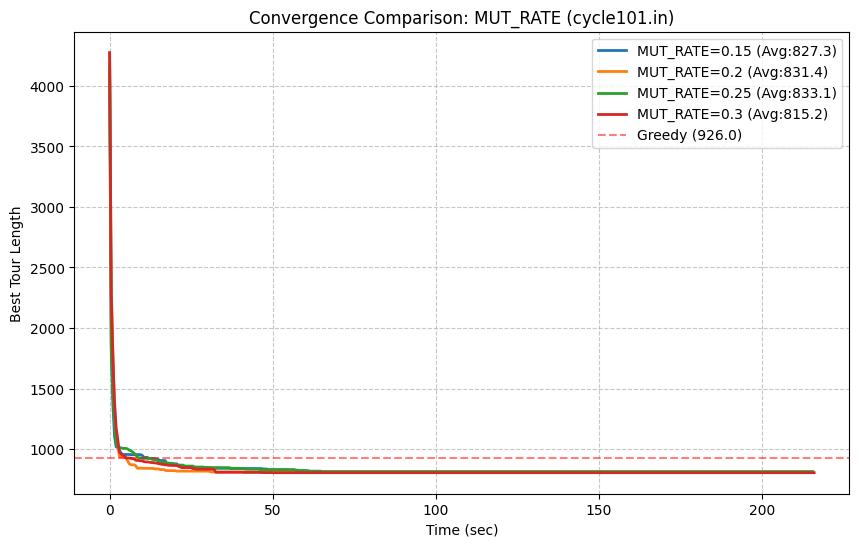

In [ ]:
# @title 260204_TOURNAMENT_T_CYCLE101
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive

# ==========================================
# 1. 구글 드라이브 연결 및 경로 설정
# ==========================================
drive.mount('/content/drive')

# 사용자 경로 (본인 경로에 맞게 수정 필요)
base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix
        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]
            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1
            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])
        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)
        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]
        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    def search(self):
        generation = 0
        population = []
        for _ in range(self.params["POP_SIZE"]):
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))
        population = self.sort_population(population)

        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []
            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)
                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)
                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

            # 조기 종료(Early Stopping) 제거: 시간 끝까지 돔
            # CONV_DOM_RATIO를 1.0보다 크게 설정하여 사실상 비활성화

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부 (실험 설정)
# ==========================================
if __name__ == "__main__":

    # -----------------------------------------------------------
    # [설정 1] 대상 파일 및 시드
    # -----------------------------------------------------------
    target_filename = "cycle101.in"
    full_path = os.path.join(base_path, target_filename)
    seeds = [0, 1, 2, 3, 4]


    target_param = "MUT_RATE"        # 비교할 파라미터 이름 (Key)
    test_values  = [0.15, 0.2, 0.25, 0.3]       # 비교할 값들 (List)

    # 기본 파라미터 (Base Settings)
    base_params = {
        'MUT_RATE': 0.2,
        'POP_SIZE': 120,
        'NUM_OFFSPRING': 80,
        'TOURNAMENT_T': 0.7,
        'LOG_INTERVAL_SEC': 0.5,
        'CONV_MIN_GEN': 50,
        'CONV_CHECK': 10,
        'CONV_DOM_RATIO': 1.1, # [중요] 1.0보다 크면 조기 종료 절대 안 함 (시간 꽉 채움)
    }

    # ===========================================================

    if not os.path.exists(full_path):
        print(f"❌ 오류: 파일을 찾을 수 없습니다: {full_path}")
    else:
        print(f"✅ 실험 시작: {target_filename}")
        print(f"👉 비교 파라미터: {target_param} = {test_values}")

        # 1) Greedy Baseline
        tsp_greedy = TSP_GA(full_path, base_params, seed=0)
        _, greedy_len = tsp_greedy.greedy_solution()
        print(f"   Greedy Baseline = {greedy_len:.4f}\n")

        # 결과 저장용
        plot_data = {}  # { value: (time_trace, best_trace) } -> 그래프용 (가장 잘 된 시드)

        # -------------------------------------------------------
        # 실험 루프 (설정한 값들을 하나씩 테스트)
        # -------------------------------------------------------
        for val in test_values:
            print(f"🟦 [Experiment] {target_param} = {val}")

            # 파라미터 업데이트
            current_params = base_params.copy()
            current_params[target_param] = val

            # POP_SIZE 변경 시 NUM_OFFSPRING도 같이 맞춰주는 편의 로직
            if target_param == 'POP_SIZE':
                current_params['NUM_OFFSPRING'] = val

            # 시드별 결과 저장
            seed_results = []     # best_len 저장
            seed_traces = []      # trace 저장

            print(f"   {'Seed':>4} | {'Best_Len':>12} | {'Improv(%)':>10} | {'Generations':>11}")
            print("   " + "-"*45)

            best_run_score = float('inf')
            best_run_trace = None

            for s in seeds:
                tsp = TSP_GA(full_path, current_params, seed=s)

                # 탐색 수행
                best_tour, best_len, gen, elapsed, trace = tsp.search()

                imp = (greedy_len - best_len) / greedy_len * 100.0
                seed_results.append(best_len)
                seed_traces.append(trace)

                print(f"   {s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

                # 그래프 그리기 위해 "가장 결과가 좋았던 시드"의 궤적을 저장
                if best_len < best_run_score:
                    best_run_score = best_len
                    best_run_trace = trace

            # 평균 계산
            mean_len = statistics.mean(seed_results)
            stdev_len = statistics.stdev(seed_results) if len(seeds)>1 else 0.0
            print("   " + "-"*45)
            print(f"   ➡ Avg Best Len: {mean_len:.4f} ± {stdev_len:.4f}\n")

            # 그래프 데이터 저장 (해당 파라미터 값의 Best Run 궤적)
            plot_data[val] = (best_run_trace, mean_len)

        # -------------------------------------------------------
        # 수렴 곡선 비교 그래프 출력 (Matplotlib)
        # -------------------------------------------------------
        plt.figure(figsize=(10, 6))

        for val, (trace, avg_score) in plot_data.items():
            t_data, best_data = trace
            # 범례에 평균 점수도 같이 표시
            label_str = f"{target_param}={val} (Avg:{avg_score:.1f})"
            plt.plot(t_data, best_data, label=label_str, linewidth=2)

        plt.axhline(y=greedy_len, color='r', linestyle='--', label=f'Greedy ({greedy_len:.1f})', alpha=0.5)

        plt.xlabel("Time (sec)")
        plt.ylabel("Best Tour Length")
        plt.title(f"Convergence Comparison: {target_param} ({target_filename})")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', alpha=0.7)
        plt.show()

In [ ]:
# @title 260204_POP_SIZE_CYCLE101
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive

# ==========================================
# 1. 구글 드라이브 연결 및 경로 설정
# ==========================================
drive.mount('/content/drive')

# 사용자 경로 (본인 경로에 맞게 수정 필요)
base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix
        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]
            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1
            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])
        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)
        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]
        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    def search(self):
        generation = 0
        population = []
        for _ in range(self.params["POP_SIZE"]):
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))
        population = self.sort_population(population)

        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []
            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)
                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)
                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

            # 조기 종료(Early Stopping) 제거: 시간 끝까지 돔
            # CONV_DOM_RATIO를 1.0보다 크게 설정하여 사실상 비활성화

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부 (실험 설정)
# ==========================================
if __name__ == "__main__":

    # -----------------------------------------------------------
    # [설정 1] 대상 파일 및 시드
    # -----------------------------------------------------------
    target_filename = "cycle101.in"
    full_path = os.path.join(base_path, target_filename)
    seeds = [0, 1, 2, 3, 4]


    target_param = "POP_SIZE"        # 비교할 파라미터 이름 (Key)
    test_values  = [120, 150, 200]       # 비교할 값들 (List)

    # 기본 파라미터 (Base Settings)
    base_params = {
        'MUT_RATE': 0.3,
        'POP_SIZE': 120,
        'NUM_OFFSPRING': 100,
        'TOURNAMENT_T': 0.7,
        'LOG_INTERVAL_SEC': 0.5,
        'CONV_MIN_GEN': 50,
        'CONV_CHECK': 10,
        'CONV_DOM_RATIO': 1.1, # [중요] 1.0보다 크면 조기 종료 절대 안 함 (시간 꽉 채움)
    }

    # ===========================================================

    if not os.path.exists(full_path):
        print(f"❌ 오류: 파일을 찾을 수 없습니다: {full_path}")
    else:
        print(f"✅ 실험 시작: {target_filename}")
        print(f"👉 비교 파라미터: {target_param} = {test_values}")

        # 1) Greedy Baseline
        tsp_greedy = TSP_GA(full_path, base_params, seed=0)
        _, greedy_len = tsp_greedy.greedy_solution()
        print(f"   Greedy Baseline = {greedy_len:.4f}\n")

        # 결과 저장용
        plot_data = {}  # { value: (time_trace, best_trace) } -> 그래프용 (가장 잘 된 시드)

        # -------------------------------------------------------
        # 실험 루프 (설정한 값들을 하나씩 테스트)
        # -------------------------------------------------------
        for val in test_values:
            print(f"🟦 [Experiment] {target_param} = {val}")

            # 파라미터 업데이트
            current_params = base_params.copy()
            current_params[target_param] = val

            # POP_SIZE 변경 시 NUM_OFFSPRING도 같이 맞춰주는 편의 로직
            if target_param == 'POP_SIZE':
                current_params['NUM_OFFSPRING'] = val

            # 시드별 결과 저장
            seed_results = []     # best_len 저장
            seed_traces = []      # trace 저장

            print(f"   {'Seed':>4} | {'Best_Len':>12} | {'Improv(%)':>10} | {'Generations':>11}")
            print("   " + "-"*45)

            best_run_score = float('inf')
            best_run_trace = None

            for s in seeds:
                tsp = TSP_GA(full_path, current_params, seed=s)

                # 탐색 수행
                best_tour, best_len, gen, elapsed, trace = tsp.search()

                imp = (greedy_len - best_len) / greedy_len * 100.0
                seed_results.append(best_len)
                seed_traces.append(trace)

                print(f"   {s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

                # 그래프 그리기 위해 "가장 결과가 좋았던 시드"의 궤적을 저장
                if best_len < best_run_score:
                    best_run_score = best_len
                    best_run_trace = trace

            # 평균 계산
            mean_len = statistics.mean(seed_results)
            stdev_len = statistics.stdev(seed_results) if len(seeds)>1 else 0.0
            print("   " + "-"*45)
            print(f"   ➡ Avg Best Len: {mean_len:.4f} ± {stdev_len:.4f}\n")

            # 그래프 데이터 저장 (해당 파라미터 값의 Best Run 궤적)
            plot_data[val] = (best_run_trace, mean_len)

        # -------------------------------------------------------
        # 수렴 곡선 비교 그래프 출력 (Matplotlib)
        # -------------------------------------------------------
        plt.figure(figsize=(10, 6))

        for val, (trace, avg_score) in plot_data.items():
            t_data, best_data = trace
            # 범례에 평균 점수도 같이 표시
            label_str = f"{target_param}={val} (Avg:{avg_score:.1f})"
            plt.plot(t_data, best_data, label=label_str, linewidth=2)

        plt.axhline(y=greedy_len, color='r', linestyle='--', label=f'Greedy ({greedy_len:.1f})', alpha=0.5)

        plt.xlabel("Time (sec)")
        plt.ylabel("Best Tour Length")
        plt.title(f"Convergence Comparison: {target_param} ({target_filename})")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', alpha=0.7)
        plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 실험 시작: cycle101.in
👉 비교 파라미터: POP_SIZE = [120, 150, 200]
   Greedy Baseline = 926.0428

🟦 [Experiment] POP_SIZE = 120
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     851.0793 |       8.10 |       67952
      1 |     843.9134 |       8.87 |       67909
      2 |     796.2395 |      14.02 |       68035
      3 |     826.1165 |      10.79 |       68268
      4 |     833.9558 |       9.94 |       68206
   ---------------------------------------------
   ➡ Avg Best Len: 830.2609 ± 21.2607

🟦 [Experiment] POP_SIZE = 150
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     834.6951 |       9.86 |       53750
      1 |     818.1233 |      11.65 |       54048
      2 |     823.7703 |      11.04 |       53961
      3 |     850.8399 |       8.12

KeyboardInterrupt: 

In [ ]:
# @title 260204_TOURNAMENT_T_CYCLE101
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive

# ==========================================
# 1. 구글 드라이브 연결 및 경로 설정
# ==========================================
drive.mount('/content/drive')

# 사용자 경로 (본인 경로에 맞게 수정 필요)
base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix
        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]
            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1
            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])
        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)
        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]
        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    def search(self):
        generation = 0
        population = []
        for _ in range(self.params["POP_SIZE"]):
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))
        population = self.sort_population(population)

        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []
            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)
                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)
                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

            # 조기 종료(Early Stopping) 제거: 시간 끝까지 돔
            # CONV_DOM_RATIO를 1.0보다 크게 설정하여 사실상 비활성화

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부 (실험 설정)
# ==========================================
if __name__ == "__main__":

    # -----------------------------------------------------------
    # [설정 1] 대상 파일 및 시드
    # -----------------------------------------------------------
    target_filename = "cycle101.in"
    full_path = os.path.join(base_path, target_filename)
    seeds = [0, 1, 2, 3, 4]


    target_param = "TOURNAMENT_T"        # 비교할 파라미터 이름 (Key)
    test_values  = [0.75, 0.8]       # 비교할 값들 (List)

    # 기본 파라미터 (Base Settings)
    base_params = {
        'MUT_RATE': 0.3,
        'POP_SIZE': 120,
        'NUM_OFFSPRING': 80,
        'TOURNAMENT_T': 0.7,
        'LOG_INTERVAL_SEC': 0.5,
        'CONV_MIN_GEN': 50,
        'CONV_CHECK': 10,
        'CONV_DOM_RATIO': 1.1, # [중요] 1.0보다 크면 조기 종료 절대 안 함 (시간 꽉 채움)
    }

    # ===========================================================

    if not os.path.exists(full_path):
        print(f"❌ 오류: 파일을 찾을 수 없습니다: {full_path}")
    else:
        print(f"✅ 실험 시작: {target_filename}")
        print(f"👉 비교 파라미터: {target_param} = {test_values}")

        # 1) Greedy Baseline
        tsp_greedy = TSP_GA(full_path, base_params, seed=0)
        _, greedy_len = tsp_greedy.greedy_solution()
        print(f"   Greedy Baseline = {greedy_len:.4f}\n")

        # 결과 저장용
        plot_data = {}  # { value: (time_trace, best_trace) } -> 그래프용 (가장 잘 된 시드)

        # -------------------------------------------------------
        # 실험 루프 (설정한 값들을 하나씩 테스트)
        # -------------------------------------------------------
        for val in test_values:
            print(f"🟦 [Experiment] {target_param} = {val}")

            # 파라미터 업데이트
            current_params = base_params.copy()
            current_params[target_param] = val

            # POP_SIZE 변경 시 NUM_OFFSPRING도 같이 맞춰주는 편의 로직
            if target_param == 'POP_SIZE':
                current_params['NUM_OFFSPRING'] = val

            # 시드별 결과 저장
            seed_results = []     # best_len 저장
            seed_traces = []      # trace 저장

            print(f"   {'Seed':>4} | {'Best_Len':>12} | {'Improv(%)':>10} | {'Generations':>11}")
            print("   " + "-"*45)

            best_run_score = float('inf')
            best_run_trace = None

            for s in seeds:
                tsp = TSP_GA(full_path, current_params, seed=s)

                # 탐색 수행
                best_tour, best_len, gen, elapsed, trace = tsp.search()

                imp = (greedy_len - best_len) / greedy_len * 100.0
                seed_results.append(best_len)
                seed_traces.append(trace)

                print(f"   {s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

                # 그래프 그리기 위해 "가장 결과가 좋았던 시드"의 궤적을 저장
                if best_len < best_run_score:
                    best_run_score = best_len
                    best_run_trace = trace

            # 평균 계산
            mean_len = statistics.mean(seed_results)
            stdev_len = statistics.stdev(seed_results) if len(seeds)>1 else 0.0
            print("   " + "-"*45)
            print(f"   ➡ Avg Best Len: {mean_len:.4f} ± {stdev_len:.4f}\n")

            # 그래프 데이터 저장 (해당 파라미터 값의 Best Run 궤적)
            plot_data[val] = (best_run_trace, mean_len)

        # -------------------------------------------------------
        # 수렴 곡선 비교 그래프 출력 (Matplotlib)
        # -------------------------------------------------------
        plt.figure(figsize=(10, 6))

        for val, (trace, avg_score) in plot_data.items():
            t_data, best_data = trace
            # 범례에 평균 점수도 같이 표시
            label_str = f"{target_param}={val} (Avg:{avg_score:.1f})"
            plt.plot(t_data, best_data, label=label_str, linewidth=2)

        plt.axhline(y=greedy_len, color='r', linestyle='--', label=f'Greedy ({greedy_len:.1f})', alpha=0.5)

        plt.xlabel("Time (sec)")
        plt.ylabel("Best Tour Length")
        plt.title(f"Convergence Comparison: {target_param} ({target_filename})")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', alpha=0.7)
        plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 실험 시작: cycle101.in
👉 비교 파라미터: TOURNAMENT_T = [0.75, 0.8]
   Greedy Baseline = 926.0428

🟦 [Experiment] TOURNAMENT_T = 0.75
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     823.5384 |      11.07 |      103438
      1 |     825.2576 |      10.88 |      103612
      2 |     825.9987 |      10.80 |      103508
      3 |     827.6003 |      10.63 |      103889
      4 |     815.0352 |      11.99 |      103595
   ---------------------------------------------
   ➡ Avg Best Len: 823.4860 ± 4.9446

🟦 [Experiment] TOURNAMENT_T = 0.8
   Seed |     Best_Len |  Improv(%) | Generations
   ---------------------------------------------
      0 |     844.6342 |       8.79 |      103774
      1 |     859.2201 |       7.22 |      101843
      2 |     801.2042 |      13.48 |      103354


# 260204_CYCLE 21_exp

In [ ]:
# @title Best params + greedy
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive

# ==========================================
# 1. 구글 드라이브 연결 및 경로 설정
# ==========================================
drive.mount('/content/drive')

# 사용자 경로 (본인 경로에 맞게 수정 필요)
base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix
        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]
            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1
            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])
        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)
        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]
        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    def print_average_fitness(self, population):
        avg = sum(f for _, f in population) / len(population)
        best = population[0][1]
        # print(f"[Gen] avg_len={avg:.4f}, best_len={best:.4f}")

    # [수정] 외부에서 초기 해(Greedy)를 받아올 수 있도록 init_tours 매개변수 추가
    def search(self, init_tours=None):
        generation = 0
        population = []

        # 1-1) Greedy Seed 주입 (전달받은 해가 있다면 우선 추가)
        if init_tours:
            for tour in init_tours:
                if len(population) < self.params["POP_SIZE"]:
                    fit = self.get_fitness(tour)
                    population.append((tour, fit))

        # 1-2) 남은 자리는 랜덤 해로 채우기
        while len(population) < self.params["POP_SIZE"]:
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))

        population = self.sort_population(population)

        # 2) 시간 및 trace 초기화
        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        # 3) 제한시간 루프
        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []

            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)

                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)

                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

            # 조기 종료(Early Stopping) 제거: 시간 끝까지 돔
            # CONV_DOM_RATIO를 1.0보다 크게 설정하여 사실상 비활성화

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부
# ==========================================
if __name__ == "__main__":

    # 3. 대상 파일명 설정
    target_filename = "cycle21.in"

    # 전체 경로 결합
    full_path = os.path.join(base_path, target_filename)

    print(f"Dataset Path: {full_path}")

    # 파일 존재 여부 확인
    if not os.path.exists(full_path):
        print(f"❌ 오류: 파일을 찾을 수 없습니다.: {full_path}")
    else:
        print(f"✅ 파일을 찾았습니다! 실험을 시작합니다.")

        seeds = [0, 1, 2, 3, 4]

        # 파라미터 설정
        params = {
            'MUT_RATE': 0.25,
            'POP_SIZE': 120,
            'NUM_OFFSPRING': 70,
            'TOURNAMENT_T': 0.8,
            'LOG_INTERVAL_SEC': 0.5, # 로그 간격 조정
            # 조기 종료를 사실상 끄기 위해 비율을 1.0 초과로 설정
            'CONV_DOM_RATIO': 1.1,
        }

        print(f"\n==========================================")
        print(f"[Experiment] {target_filename} (With Greedy Init)")

        # 1) Greedy (Baseline) 계산 및 경로 저장
        tsp_greedy = TSP_GA(full_path, params, seed=0)
        greedy_tour, greedy_len = tsp_greedy.greedy_solution() # [중요] 경로(greedy_tour)도 받음

        # 파일에서 읽어온 제한 시간 확인
        limit_time_val = tsp_greedy.limit_time

        print(f"Greedy(start=0) Len = {greedy_len:.4f}")
        print(f"Time Limit          = {limit_time_val} seconds per seed")
        print("------------------------------------------")
        print(f"{'seed':>4} | {'GA_best_len':>12} | {'improve(%)':>10} | {'Generations':>11}")
        print("-" * 52)

        ga_results = []
        improvements = []

        # 시드별 반복 실행
        for s in seeds:
            # GA 객체 생성
            tsp = TSP_GA(full_path, params, seed=s)

            # [수정] Greedy 경로를 초기값 리스트에 담아 전달
            best_tour, best_len, gen, elapsed, trace = tsp.search(init_tours=[greedy_tour])

            # 개선율 계산
            imp = (greedy_len - best_len) / greedy_len * 100.0

            ga_results.append(best_len)
            improvements.append(imp)

            print(f"{s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

        # 모든 시드 종료 후 최종 요약 출력
        mean_len = statistics.mean(ga_results)
        stdev_len = statistics.stdev(ga_results) if len(seeds) > 1 else 0.0
        mean_imp = statistics.mean(improvements)
        stdev_imp = statistics.stdev(improvements) if len(seeds) > 1 else 0.0

        print("-" * 52)
        print(f"[Summary] {target_filename} (5 Runs)")
        print(f"GA_best_len (Mean ± Std) : {mean_len:.4f} ± {stdev_len:.4f}")
        print(f"Improvement (Mean ± Std) : {mean_imp:.2f}% ± {stdev_imp:.2f}%")
        print("==========================================\n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Path: /content/drive/MyDrive/SDMLAB/260129_TSP/cycle21.in
✅ 파일을 찾았습니다! 실험을 시작합니다.

[Experiment] cycle21.in (With Greedy Init)
Greedy(start=0) Len = 552.8773
Time Limit          = 24.0 seconds per seed
------------------------------------------
seed |  GA_best_len | improve(%) | Generations
----------------------------------------------------
   0 |     399.7112 |      27.70 |       37288
   1 |     418.5101 |      24.30 |       37781
   2 |     399.7112 |      27.70 |       37886
   3 |     399.7112 |      27.70 |       38470
   4 |     399.7112 |      27.70 |       39403
----------------------------------------------------
[Summary] cycle21.in (5 Runs)
GA_best_len (Mean ± Std) : 403.4710 ± 8.4072
Improvement (Mean ± Std) : 27.02% ± 1.52%



In [ ]:
# @title Best Params without greedy(random initialization)
import random
import math
import time
import statistics
import copy
from collections import Counter
import matplotlib.pyplot as plt
import os
from google.colab import drive


drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/SDMLAB/260129_TSP"

# ==========================================
# 2. TSP_GA 클래스 정의
# ==========================================
class TSP_GA:
    def __init__(self, file_path, params, seed=0):
        self.params = params
        self.rng = random.Random(seed)

        self.cities = []
        self.limit_time = 0
        self.n_cities = 0

        self.load_data(file_path)
        self.dist_matrix = self.precompute_distances()

        self.trace_t = []
        self.trace_best = []

    def load_data(self, file_path):
        """
        입력 형식: N, 좌표들..., TimeLimit
        """
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]

        self.n_cities = int(float(lines[0]))
        self.limit_time = float(lines[-1])

        coord_lines = lines[1:1 + self.n_cities]
        self.cities = []
        for i, ln in enumerate(coord_lines):
            parts = ln.split()
            if len(parts) != 2:
                raise ValueError(f"{i + 1}번째 좌표 줄이 'x y' 형식이 아닙니다: '{ln}'")
            x, y = map(float, parts)
            self.cities.append((x, y))

    def precompute_distances(self):
        matrix = [[0.0] * self.n_cities for _ in range(self.n_cities)]
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                d = math.sqrt((self.cities[i][0] - self.cities[j][0]) ** 2 +
                              (self.cities[i][1] - self.cities[j][1]) ** 2)
                matrix[i][j] = d
                matrix[j][i] = d
        return matrix

    def get_fitness(self, chromosome):
        distance = 0
        for i in range(self.n_cities):
            a = chromosome[i]
            b = chromosome[(i + 1) % self.n_cities]
            distance += self.dist_matrix[a][b]
        return distance

    def greedy_solution(self):
        start = 0
        n = self.n_cities
        dm = self.dist_matrix

        visited = [False] * n
        tour = [start]
        visited[start] = True
        cur = start

        for k in range(n - 1):
            nxt = None
            best_d = float("inf")
            for j in range(n):
                if not visited[j]:
                    d = dm[cur][j]
                    if d < best_d:
                        best_d = d
                        nxt = j
            tour.append(nxt)
            visited[nxt] = True
            cur = nxt

        best_len = self.get_fitness(tour)
        return tour, best_len

    def random_tour(self):
        t = list(range(self.n_cities))
        self.rng.shuffle(t)
        return t

    def sort_population(self, population):
        population.sort(key=lambda x: x[1])
        return population

    def selection_operater(self, population):
        t = self.params['TOURNAMENT_T']

        def tourna():
            ch1, fit1 = population[self.rng.randrange(len(population))]
            ch2, fit2 = population[self.rng.randrange(len(population))]

            if fit2 < fit1:
                ch1, ch2 = ch2, ch1
                fit1, fit2 = fit2, fit1

            r = self.rng.random()
            if t > r:
                return ch1
            else:
                return ch2

        mom_ch = tourna()
        dad_ch = tourna()
        return mom_ch, dad_ch

    def crossover_operater(self, mom, dad):
        n = self.n_cities
        l = self.rng.randrange(n)
        r = self.rng.randrange(n)
        while r == l:
            r = self.rng.randrange(n)
        if l > r:
            l, r = r, l

        child = [-1] * n
        child[l:r + 1] = mom[l:r + 1]
        used = set(child[l:r + 1])

        idx = (r + 1) % n
        for city in dad:
            if city in used:
                continue
            while child[idx] != -1:
                idx = (idx + 1) % n
            child[idx] = city
            used.add(city)

        return child

    def mutation_operater(self, chromosome):
        n = self.n_cities
        a = self.rng.randrange(n)
        b = self.rng.randrange(n)
        if a > b:
            a, b = b, a
        if a == b:
            return chromosome[:]

        ch = chromosome[:]
        ch[a:b+1] = reversed(ch[a:b+1])
        return ch

    def replacement_operator(self, population, offsprings):
        merged = population + offsprings
        merged.sort(key=lambda x: x[1])
        return merged[:self.params['POP_SIZE']]

    def print_average_fitness(self, population):
        avg = sum(f for _, f in population) / len(population)
        best = population[0][1]
        # 출력 양이 너무 많으면 이 부분 주석 처리 가능
        # print(f"[Gen] avg_len={avg:.4f}, best_len={best:.4f}")

    def search(self):
        generation = 0
        population = []

        # 1) 초기화
        for _ in range(self.params["POP_SIZE"]):
            ch = self.random_tour()
            fit = self.get_fitness(ch)
            population.append((ch, fit))

        population = self.sort_population(population)

        # 2) 시간 및 trace 초기화
        start_time = time.time()
        last_log = 0.0
        self.trace_t = [0.0]
        self.trace_best = [population[0][1]]
        log_interval = self.params.get("LOG_INTERVAL_SEC", 0.2)

        # 3) 제한시간 루프
        while (time.time() - start_time) < self.limit_time:
            generation += 1
            offsprings = []

            for _ in range(self.params["NUM_OFFSPRING"]):
                mom_ch, dad_ch = self.selection_operater(population)
                child = self.crossover_operater(mom_ch, dad_ch)

                if self.rng.random() < self.params["MUT_RATE"]:
                    child = self.mutation_operater(child)

                child_fit = self.get_fitness(child)
                offsprings.append((child, child_fit))

            population = self.replacement_operator(population, offsprings)

            elapsed = time.time() - start_time
            if elapsed - last_log >= log_interval:
                last_log = elapsed
                self.trace_t.append(elapsed)
                self.trace_best.append(population[0][1])

        best_ch, best_fit = population[0]
        elapsed = time.time() - start_time
        return best_ch, best_fit, generation, elapsed, (self.trace_t, self.trace_best)

# ==========================================
# 3. 메인 실행부
# ==========================================
if __name__ == "__main__":

    # 3. 대상 파일명 설정
    target_filename = "cycle21.in"

    # 전체 경로 결합
    full_path = os.path.join(base_path, target_filename)

    print(f"Dataset Path: {full_path}")

    # 파일 존재 여부 확인
    if not os.path.exists(full_path):
        print(f"오류: 파일을 찾을 수 없습니다.: {full_path}")
    else:
        print(f"파일을 찾았습니다! 실험을 시작합니다.")


        seeds = [0, 1, 2, 3, 4]

        # 파라미터 설정
        params = {
            'MUT_RATE': 0.25,
            'POP_SIZE': 120,
            'NUM_OFFSPRING': 70,
            'TOURNAMENT_T': 0.8,
            'LOG_INTERVAL_SEC': 0.5, # 로그 간격 조정
        }

        print(f"\n==========================================")
        print(f"[Experiment] {target_filename}")

        # Greedy (Baseline) 계산
        tsp_greedy = TSP_GA(full_path, params, seed=0)
        _, greedy_len = tsp_greedy.greedy_solution()

        # 파일에서 읽어온 제한 시간 확인
        limit_time_val = tsp_greedy.limit_time

        print(f"Greedy(start=0) Len = {greedy_len:.4f}")
        print(f"Time Limit          = {limit_time_val} seconds per seed")
        print("------------------------------------------")
        print(f"{'seed':>4} | {'GA_best_len':>12} | {'improve(%)':>10} | {'Generations':>11}")
        print("-" * 52)

        ga_results = []
        improvements = []

        # 시드별 반복 실행
        for s in seeds:
            # GA 객체 생성
            tsp = TSP_GA(full_path, params, seed=s)

            # 탐색 시작
            best_tour, best_len, gen, elapsed, trace = tsp.search()

            # 개선율 계산
            imp = (greedy_len - best_len) / greedy_len * 100.0

            ga_results.append(best_len)
            improvements.append(imp)

            print(f"{s:>4} | {best_len:>12.4f} | {imp:>10.2f} | {gen:>11}")

        # 모든 시드 종료 후 최종 요약 출력
        mean_len = statistics.mean(ga_results)
        stdev_len = statistics.stdev(ga_results) if len(seeds) > 1 else 0.0
        mean_imp = statistics.mean(improvements)
        stdev_imp = statistics.stdev(improvements) if len(seeds) > 1 else 0.0

        print("-" * 52)
        print(f"[Summary] {target_filename} (5 Runs)")
        print(f"GA_best_len (Mean ± Std) : {mean_len:.4f} ± {stdev_len:.4f}")
        print(f"Improvement (Mean ± Std) : {mean_imp:.2f}% ± {stdev_imp:.2f}%")
        print("==========================================\n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Path: /content/drive/MyDrive/SDMLAB/260129_TSP/cycle21.in
파일을 찾았습니다! 실험을 시작합니다.

[Experiment] cycle21.in
Greedy(start=0) Len = 552.8773
Time Limit          = 24.0 seconds per seed
------------------------------------------
seed |  GA_best_len | improve(%) | Generations
----------------------------------------------------
   0 |     399.7112 |      27.70 |       39683
   1 |     399.7112 |      27.70 |       38014
   2 |     399.7112 |      27.70 |       37398
   3 |     399.7112 |      27.70 |       37463
   4 |     406.1384 |      26.54 |       37554
----------------------------------------------------
[Summary] cycle21.in (5 Runs)
GA_best_len (Mean ± Std) : 400.9966 ± 2.8744
Improvement (Mean ± Std) : 27.47% ± 0.52%

